# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

DynamicPPL.Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DynamicPPL.DefaultContext()))

## MCHMC

In [5]:
funnel_target = NealFunnelTarget(funnel_model; d=d, compute_MAP=false)
funnel_target.d = d
funnel_spl = MCHMC(0.0, 0.5; init_eps=0.3, varE_wanted=1.0, sigma=ones(d));

In [6]:
funnel_samples_mchmc = Sample(funnel_spl, funnel_target, 100000;
                        dialog=true);

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Using given L ✅


eps: 0.3 --> VarE: 0.0012687902075336132
eps: 0.8144505258457835 --> VarE: 14.664210280053933
eps: 1.844983035276926e-6 --> VarE: 3.241636255965436e-12
eps: 4.559931039573464e-6 --> VarE: 2.3806900775113745e-11
eps: 1.0783481547355883e-5 --> VarE: 1.437708977761926e-10
eps: 2.4452836705753733e-5 --> VarE: 6.171345047093941e-10
eps: 5.32792533518257e-5 --> VarE: 3.3277522980157642e-9
eps: 0.00011176128700592706 --> VarE: 9.596523139198465e-9
eps: 0.00022611716940968947 --> VarE: 4.75273282987063e-8
eps: 0.00044202804390628124 --> VarE: 1.2415336015490798e-7
eps: 0.0008363117081877538 --> VarE: 1.0196880697674142e-6
eps: 0.001533842711072661 --> VarE: 2.0958120271682487e-6
eps: 0.0027311554563412255 --> VarE: 1.2559623162434145e-5
eps: 0.004728128730338422 --> VarE: 3.9636834615712464e-5
eps: 0.007968964753711888 --> VarE: 7.71781613984541e-5
eps: 0.013093312055551538 --> VarE: 0.0002591314781328946
eps: 0.020996289201727095 --> VarE: 0.0007455987965394476
eps: 0.03289562474362819 --> Va

[ Info: Found eps: 0.5018902307569111 ✅


In [7]:
theta_mchmc = [sample[1] for sample in funnel_samples_mchmc]
x10_mchmc = [sample[10+1] for sample in funnel_samples_mchmc];

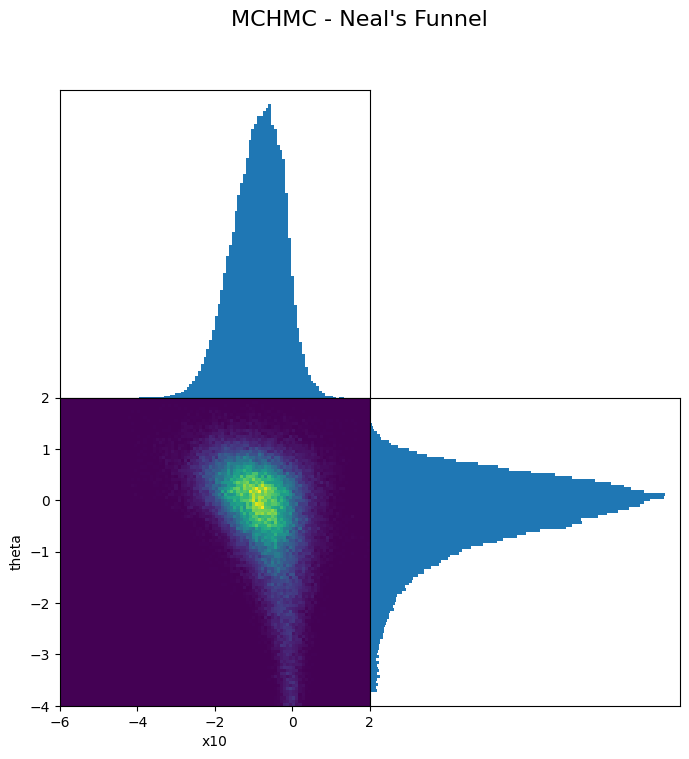

In [8]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## NUTS

In [9]:
funnel_samples_hmc = sample(funnel_model, NUTS(10, 0.95), 100000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30


Chains MCMC chain (100000×33×1 Array{Float64, 3}):

Iterations        = 11:1:100010
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 35.43 seconds
Compute duration  = 35.43 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse           ess      rhat  ⋯
      Symbol   Float64   Float64    Float64   Float64       Float64   Float64  ⋯

           θ   -0.0475    0.8046     0.0025    0.0125     4154.2321    1.0000  ⋯
        z[1]    0.3600    0.7151     0.0023    0.0021   147494.4932    1.0000  ⋯
        z[2]   -0.3532    0.7135     0.0023    0.0021   142185.2807    1.0000  ⋯
        z[3]   -

In [10]:
theta_hmc = [funnel_samples_hmc.value.data[i, 1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]]
x10_hmc = [funnel_samples_hmc.value.data[i, 10+1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]];

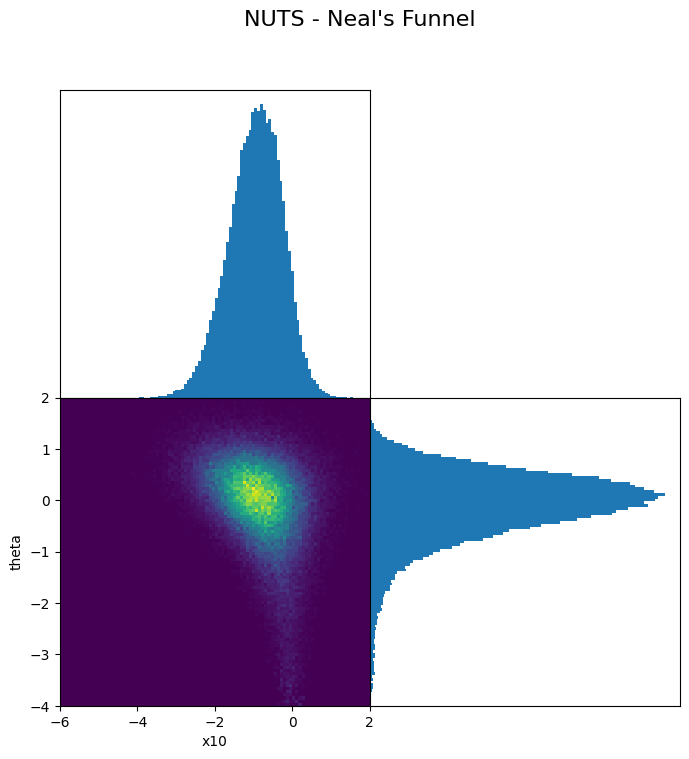

In [11]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("NUTS - Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

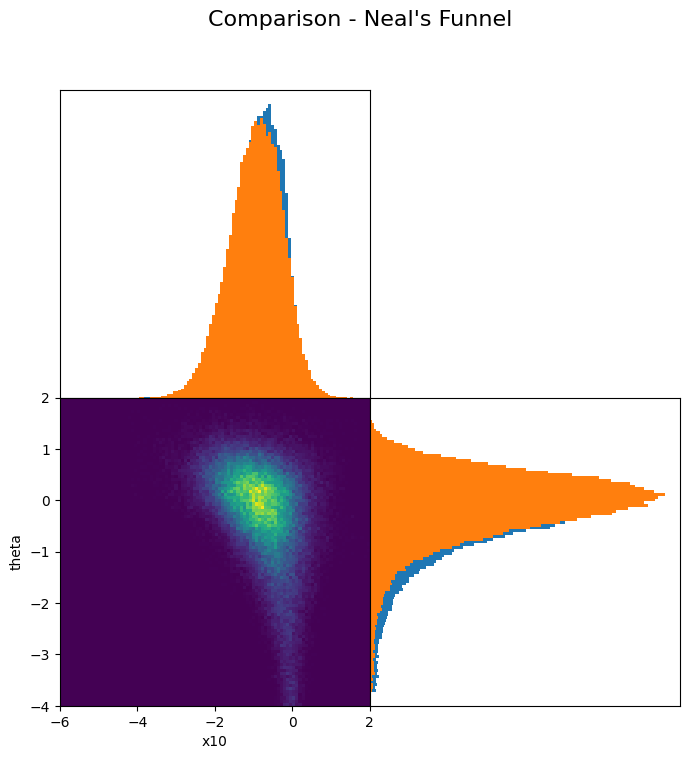

In [12]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Comparison - Neal's Funnel", fontsize=16)
fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4,2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");